# Dike Model Multi-Objective Analysis

In [48]:
# import libraries
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Policy,
    Constraint,
    save_results,
)

from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume)
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import parcoords

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## 1) Problem formulation

In [87]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    model, steps = get_model_for_problem_formulation(3)

    reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "discount rate 0": 3.5,
        "discount rate 1": 3.5,
        "discount rate 2": 3.5,
        "ID flood wave shape": 4,
    }
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split("_")

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario("reference", **scen1)

    convergence_metrics = [EpsilonProgress(),
                           HyperVolume(minimum=[0]* len(model.outcomes), maximum=[1.1]* len(model.outcomes)),
                           ]
    #determine epsilon
    epsilon = [1e3] * len(model.outcomes)
    nfe = 1
    #multiprocessing
    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            epsilons=epsilon,
            convergence=convergence_metrics,
            reference=ref_scenario,
        )

[MainProcess/INFO] pool started with 8 workers




  0%|                                                    | 0/1 [00:00<?, ?it/s]



100it [00:12,  7.72it/s]                                                       
[MainProcess/INFO] optimization completed, found 66 solutions
[MainProcess/INFO] terminating pool


In [ ]:
#save results
# save_results(results, './results/dikeoptimization_problem3_test.tar.gz')

In [7]:
#load results
#results1, convergence1 = load_results('results/dikeoptimization_problem3.tar.gz')

## 2) Searching for candidate solutions

### Assessing epsilon values

Because there are more than 3 outcomes of interest, results are visualized  using a parallel coordinate plot. (From the course material) -> In a parallel coordinate plot, the dimensions are visualized side by side. A line connecting the dimensions is a single point in the multidimensional space. For more than 3 dimensions, parallel coordiante plots are prefered over 3d scatter plots with additional visual encodings for the other dimensions.

  0%|                                                    | 0/2 [42:58<?, ?it/s]


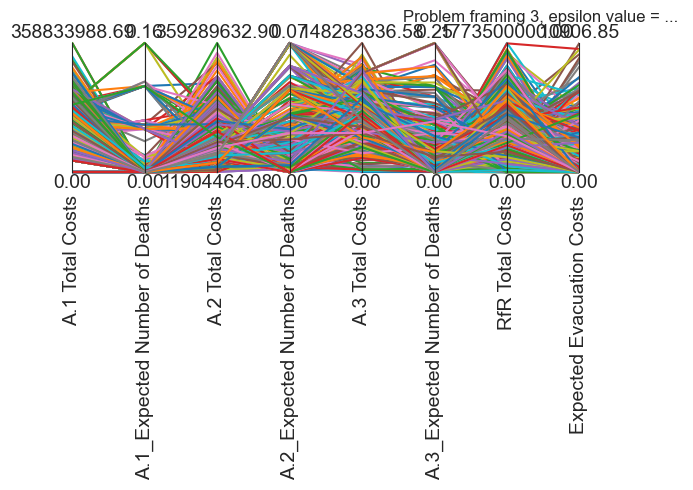

In [43]:
outcomes = results.loc[:, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.title("Problem framing 3, epsilon value = ... ")
#plt.savefig('./images/multi_obj_problem3_epsilon_test.png')
plt.show()

### Assessing the number of function evaluations (convergence)

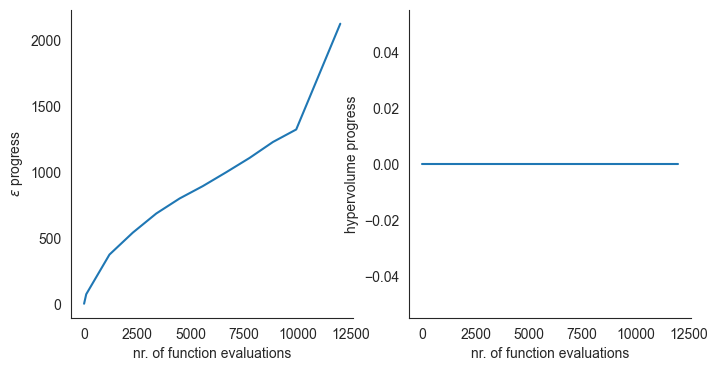

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_xlabel("nr. of function evaluations")
ax1.set_ylabel(r"$\epsilon$ progress")
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_xlabel("nr. of function evaluations")
ax2.set_ylabel("hypervolume progress")
sns.despine()

### Assessing tradeoffs and conflicting objectives

## 3) Re-evaluate candidate solutions under uncertainty

### Applying constraints

In [64]:
constraints = [
    #Constraint("Dike increase in dike ring 3", parameter_names= "A.3_DikeIncrease 0", function = lambda x: (max(0, 1-x))),
    Constraint("No casualties A1", outcome_names = "A.1_Expected Number of Deaths", function = lambda x: (max(0, 0+x))),
    Constraint("No casualties A2", outcome_names = "A.2_Expected Number of Deaths", function = lambda x: (max(0, 0+x))),
    Constraint("No casualties A3", outcome_names = "A.3_Expected Number of Deaths", function = lambda x: (max(0, 0+x))),
    Constraint("At least one RfR", outcome_names= "RfR Total Costs", function = lambda x: (max(0, 1-x))),
]

In [65]:
with MultiprocessingEvaluator(model) as evaluator:
    results_constrained, convergence_constrained = evaluator.optimize(
            nfe=2,
            searchover="levers",
            epsilons=epsilon,
            reference=ref_scenario,
            convergence=convergence_metrics,
            constraints=constraints
        )

[MainProcess/INFO] pool started with 8 workers




  0%|                                                    | 0/2 [00:00<?, ?it/s]



100it [00:12,  7.84it/s]                                                       
[MainProcess/INFO] optimization completed, found 40 solutions
[MainProcess/INFO] terminating pool


#### Running reduced-size solution set of policies

In [68]:
policies = []
for row in range(results_constrained.shape[0]):
    policies.append(
        Policy(name=row, **results.iloc[row, :-12].to_dict())
    )

In [70]:
with MultiprocessingEvaluator(model) as evaluator:
    policy_results = evaluator.perform_experiments(scenarios=5, policies = policies)

[MainProcess/INFO] pool started with 8 workers




  0%|                                                  | 0/200 [00:00<?, ?it/s]



  0%|▏                                         | 1/200 [00:01<03:30,  1.06s/it]



  4%|█▉                                        | 9/200 [00:01<00:36,  5.23it/s]



  6%|██▋                                      | 13/200 [00:02<00:25,  7.30it/s]



  8%|███                                      | 15/200 [00:02<00:21,  8.45it/s]



  8%|███▍                                     | 17/200 [00:02<00:30,  5.91it/s]



 10%|████                                     | 20/200 [00:03<00:24,  7.33it/s]



 11%|████▌                                    | 22/200 [00:03<00:24,  7.28it/s]



 12%|█████▏                                   | 25/200 [00:04<00:26,  6.58it/s]



 14%|█████▋                                   | 28/200 [00:04<00:25,  6.81it/s]



 15%|██████▏                                  | 30/200 [00:04<00:23,  7.20it/s]



 16%|██████▌                        

#### Determining robustness metrics

In [81]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [82]:
experiments, outcomes = policy_results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,0.000000e+00,8.762396e+15,6.945164e-04,1.254776e+15,0.000212,2.164608e+14,4.589401e-07,1.118887e+16,0.000813,0.0,1.614616e+07
1,0.000000e+00,0.000000e+00,2.000119e+16,1.726379e-02,2.603821e+15,0.000694,8.844377e+14,5.760893e-05,1.863426e+00,0.000000,0.0,0.000000e+00
2,0.000000e+00,0.000000e+00,9.733574e+14,7.386906e-07,2.182021e+15,0.000014,2.016600e+15,3.184442e-06,1.678555e+00,0.000000,0.0,1.019878e+07
3,0.000000e+00,0.000000e+00,2.897203e+15,1.713816e-03,2.378429e+15,0.003377,7.971618e+14,2.867258e-05,0.000000e+00,0.000000,0.0,0.000000e+00
4,0.000000e+00,0.000000e+00,1.046391e+16,8.719678e-03,1.153247e+15,0.000609,2.208058e+14,3.761951e-06,0.000000e+00,0.000000,0.0,0.000000e+00
5,4.791828e+14,7.617318e-08,5.813249e+15,1.465995e-05,1.710015e+15,0.000022,0.000000e+00,0.000000e+00,6.005436e+15,0.000042,0.0,2.597610e+07
6,0.000000e+00,0.000000e+00,1.017210e+16,5.147769e-03,1.210264e+15,0.001495,0.000000e+00,0.000000e+00,3.117648e+16,0.019272,0.0,0.000000e+00
7,0.000000e+00,0.000000e+00,8.575836e+15,1.801140e-03,1.335066e+15,0.000736,2.926015e+12,1.465594e-08,2.735631e+16,0.016568,0.0,0.000000e+00
8,0.000000e+00,0.000000e+00,1.746238e+16,2.217332e-02,2.450269e+15,0.002039,1.203453e-01,0.000000e+00,2.863732e+16,0.016713,0.0,0.000000e+00
9,0.000000e+00,0.000000e+00,4.820162e+16,6.129178e-02,3.568379e+16,0.045511,2.722812e+14,2.067225e-05,1.267481e+16,0.005041,0.0,0.000000e+00


C:\Users\nelen\EPA141A\venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


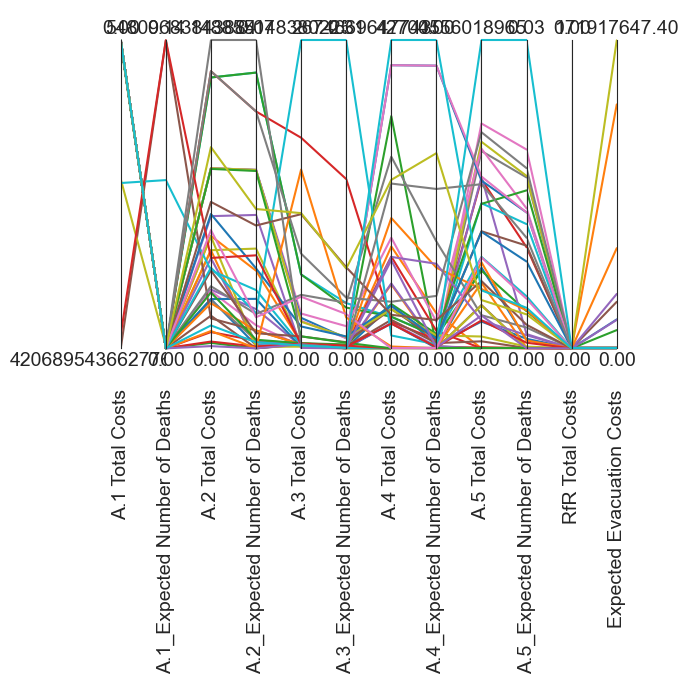

In [83]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths','RfR Total Costs', 'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('A.1 Total Costs')
plt.show()

In [88]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [89]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [ ]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

## 4) Assessing the uncertain conditions under which we get poor performance